# Programming Exercise 5: 
## Regularized Linear Regression and Bias vs Variance

### Introduction
In this exercise, you will implement regularized linear regression and use it to study models with different bias-variance properties.

In [1]:
import os
import numpy as np
from matplotlib import pyplot
from scipy import optimize
# will be used to load MATLAB mat datafile format
from scipy.io import loadmat
import utils

grader = utils.Grader()

%matplotlib inline

# 1 Regularized Linear Regression
In the first half of the exercise, i will implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir. In the next half, i will go through some diagnostics of debugging learning algorithms and examine the effects of bias v.s. variance.

## 1.1 Visualizing the dataset
We will begin by visualizing the dataset containing historical records on the change in the water level, $x$, and the amount of water flowing out of the dam, $y$. This dataset is divided into three parts:

 - A **training** set that model will learn on: X, y
 - A (cross) **validation** set for determining the regularization parameter: Xval, yval
 - A **test** set for evaluating performance. These are “unseen” examples which model did not see during training: Xtest, ytest
 
In the following parts, i will implement linear regression and use that to fit a straight line to the data and plot learning curves. Following that, i will implement polynomial regression to find a better fit to the data.

(12, 1)
(12,)


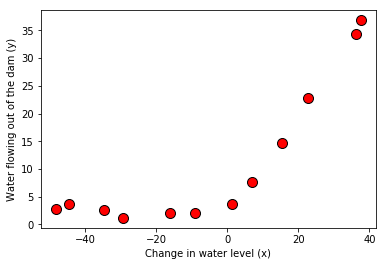

In [2]:
data = loadmat(os.path.join('Data', 'ex5data1.mat'))

X, y = data['X'], data['y'][:,0]
Xtest, ytest = data['Xtest'], data['ytest'][:, 0]
Xval, yval = data['Xval'], data['yval'][:, 0]

m = y.size

pyplot.plot(X, y, 'ro', ms = 10, mec = 'k', mew = 1)
pyplot.xlabel('Change in water level (x)')
pyplot.ylabel('Water flowing out of the dam (y)')

print(X.shape)
print(y.shape)

## 1.2 Regularized linear regression cost function
Recall that regularized linear regression has the following cost function:

$$ J(\theta) = \frac{1}{2m} \left( \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right)^2 \right) + \frac{\lambda}{2m} \left( \sum_{j=1}^n \theta_j^2 \right)$$
where $\lambda$ is a regularization parameter which controls the degree of regularization (thus, help preventing overfitting). The regularization term puts a penalty on the overall cost J. As the magnitudes of the model parameters $\theta_j$ increase, the penalty increases as well. Note that you should not regularize the $\theta_0$ term.

## 1.3 Regularized linear regression gradient
Correspondingly, the partial derivative of the cost function for regularized linear regression is defined as:

$$
\begin{align}
&amp; \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} &amp; \qquad \text{for } j = 0 \\
&amp; \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j &amp; \qquad \text{for } j \ge 1
\end{align}
$$

In [3]:
def linearRegCostFunction(X, y, theta, lambda_=0.0):

    m = y.size # number of training examples

    # You need to return the following variables correctly 
    J = 0
    grad = np.zeros(theta.shape)

    # ============================================================
                        #COST FUNCTION
        
    temp1 = (X @ theta) - y
    temp2 = theta[1:] @ theta[1:].T
    J = (temp1.T @ temp1 + lambda_*temp2)/(2*m)
    
                        #GRADIENT

    grad = (1/m)*(X.T @ (temp1))
    grad[1:] = grad[1:] + theta[1:] * (lambda_/m)
    
    # ============================================================
    return J, grad

In [4]:
theta = np.array([1, 1])
J, _ = linearRegCostFunction(np.concatenate([np.ones((m, 1)), X], axis=1), y, theta, 1)

print('Cost at theta = [1, 1]:\t   %f ' % J)
print('This value should be about 303.993192\n' % J)

Cost at theta = [1, 1]:	   303.993192 
This value should be about 303.993192



In [5]:
theta = np.array([1, 1])
J, grad = linearRegCostFunction(np.concatenate([np.ones((m, 1)), X], axis=1), y, theta, 1)

print('Gradient at theta = [1, 1]:  [{:.6f}, {:.6f}] '.format(*grad))
print(' (this value should be about [-15.303016, 598.250744])\n')

Gradient at theta = [1, 1]:  [-15.303016, 598.250744] 
 (this value should be about [-15.303016, 598.250744])



### Fitting linear regression
Once cost function and gradient are working correctly, the next cell will run the code in trainLinearReg (found in the module utils.py) to compute the optimal values of $\theta$. This training function uses scipy's optimization module to minimize the cost function.

In this part, we set regularization parameter $\lambda$ to zero. Because our current implementation of linear regression is trying to fit a 2-dimensional $\theta$, regularization will not be incredibly helpful for a $\theta$ of such low dimension. In the later parts of the exercise, i will be using polynomial regression with regularization.

The best fit line tells us that the model is not a good fit to the data because the data has a non-linear pattern. While visualizing the best fit as shown is one possible way to debug your learning algorithm, it is not always easy to visualize the data and model. In the next section, i will implement a function to generate learning curves that can help debug a learning algorithm even if it is not easy to visualize the data.

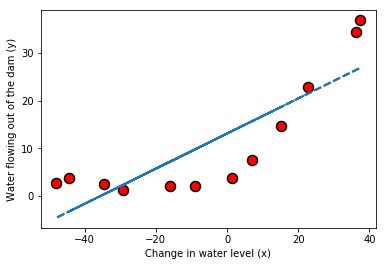

In [6]:
# add a columns of ones for the y-intercept
X_aug = np.concatenate([np.ones((m, 1)), X], axis=1)
theta = utils.trainLinearReg(linearRegCostFunction, X_aug, y, lambda_=0)

#  Plot fit over the data
pyplot.plot(X, y, 'ro', ms=10, mec='k', mew=1.5)
pyplot.xlabel('Change in water level (x)')
pyplot.ylabel('Water flowing out of the dam (y)')
pyplot.plot(X, np.dot(X_aug, theta), '--', lw=2);

# 2 Bias-variance
An important concept in machine learning is the bias-variance tradeoff. Models with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data.

In this part of the exercise, i will plot training and test errors on a learning curve to diagnose bias-variance problems.

## 2.1 Learning Curves
I will now implement code to generate the learning curves that will be useful in debugging learning algorithms. Recall that a learning curve plots training and cross validation error as a function of training set size. My job is to fill in the function learningCurve in the next cell, so that it returns a vector of errors for the training set and cross validation set.

To plot the learning curve, we need a training and cross validation set error for different training set sizes. To obtain different training set sizes, i should use different subsets of the original training set X. Specifically, for a training set size of $i$, use the first $i$ examples (i.e., X[:i, :] and y[:i]).

Recall that the training error for a dataset is defined as

$$ J_{\text{train}} = \frac{1}{2m} \left[ \sum_{i=1}^m \left(h_\theta \left( x^{(i)} \right) - y^{(i)} \right)^2 \right] $$
In particular, note that the training error does not include the regularization term. One way to compute the training error is to use your existing cost function and set $\lambda$ to 0 only when using it to compute the training error and cross validation error. When you are computing the training set error, make sure you compute it on the training subset (i.e., X[:n,:] and y[:n]) instead of the entire training set. However, for the cross validation error, you should compute it over the entire cross validation set. You should store the computed errors in the vectors error train and error val.

In [7]:
def learningCurve(X, y, Xval, yval, lambda_=0):
    
    m = y.size

    # You need to return these values correctly
    error_train = np.zeros(m)
    error_val   = np.zeros(m)

    # =============================================================
    for i in range (1, m + 1):
        
        theta = utils.trainLinearReg(linearRegCostFunction, X[:i,:], y[:i], lambda_)
        Jtest, _ = linearRegCostFunction(X[:i,:], y[:i], theta, lambda_=0.0)
        Jcv, _ = linearRegCostFunction(Xval, yval, theta, lambda_=0.0)
        
        error_train[i-1] = Jtest
        error_val[i-1] = Jcv
        
    # =============================================================
    return error_train, error_val

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	205.121096
  	2		0.000000	110.302641
  	3		3.286595	45.010231
  	4		2.842678	48.368911
  	5		13.154049	35.865165
  	6		19.443963	33.829962
  	7		20.098522	31.970986
  	8		18.172859	30.862446
  	9		22.609405	31.135998
  	10		23.261462	28.936207
  	11		24.317250	29.551432
  	12		22.373906	29.433818


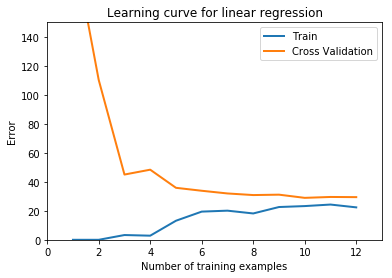

In [8]:
X_aug = np.concatenate([np.ones((m, 1)), X], axis=1)
Xval_aug = np.concatenate([np.ones((yval.size, 1)), Xval], axis=1)
error_train, error_val = learningCurve(X_aug, y, Xval_aug, yval, lambda_=0)

pyplot.plot(np.arange(1, m+1), error_train, np.arange(1, m+1), error_val, lw=2)
pyplot.title('Learning curve for linear regression')
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
pyplot.axis([0, 13, 0, 150])

print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

In the learning curve figure, you can observe that both the train error and cross validation error are high when the number of training examples is increased. This reflects a high bias problem in the model - the linear regression model is too simple and is unable to fit our dataset well. In the next section, i will implement polynomial regression to fit a better model for this dataset.

# 3 Polynomial regression
The problem with the linear model was that it was too simple for the data and resulted in underfitting (high bias). I will now address this problem by adding more features. For polynomial regression, hypothesis has the form:

$$
\begin{align}
h_\theta(x)  &= \theta_0 + \theta_1 \times (\text{waterLevel}) + \theta_2 \times (\text{waterLevel})^2 + \cdots + \theta_p \times (\text{waterLevel})^p \\
& = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_p x_p
\end{align}
$$

Notice that by defining $x_1 = (\text{waterLevel})$, $x_2 = (\text{waterLevel})^2$ , $\cdots$, $x_p =
(\text{waterLevel})^p$, we obtain a linear regression model where the features are the various powers of the original value (waterLevel).

Now, i will add more features using the higher powers of the existing feature $x$ in the dataset.

In [9]:
def polyFeatures(X, p):
    X_poly = np.zeros((X.shape[0], p))

    # ============================================================
    
    for i in range(X.shape[0]):
        for j in range(p):
            X_poly[i,j] = np.power(X[i], j+1)

    # ============================================================
    return X_poly

In [10]:
p = 8

# Map X onto Polynomial Features and Normalize
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = utils.featureNormalize(X_poly)
X_poly = np.concatenate([np.ones((m, 1)), X_poly], axis=1)

# Map X_poly_test and normalize (using mu and sigma)
X_poly_test = polyFeatures(Xtest, p)
X_poly_test -= mu
X_poly_test /= sigma
X_poly_test = np.concatenate([np.ones((ytest.size, 1)), X_poly_test], axis=1)

# Map X_poly_val and normalize (using mu and sigma)
X_poly_val = polyFeatures(Xval, p)
X_poly_val -= mu
X_poly_val /= sigma
X_poly_val = np.concatenate([np.ones((yval.size, 1)), X_poly_val], axis=1)

print('Normalized Training Example 1:')
X_poly[0, :]

Normalized Training Example 1:


array([ 1.        , -0.36214078, -0.75508669,  0.18222588, -0.70618991,
        0.30661792, -0.59087767,  0.3445158 , -0.50848117])

## 3.1 Learning Polynomial Regression
I will now proceed to train polynomial regression using the linear regression cost function.

Keep in mind that even though we have polynomial terms in our feature vector, we are still solving a linear regression optimization problem. The polynomial terms have simply turned into features that we can use for linear regression. We are using the same cost function and gradient that i wrote for the earlier part of this exercise.

For this part of the exercise, i will be using a polynomial of degree 8. It turns out that if we run the training directly on the projected data, it will not work well as the features would be badly scaled (e.g., an example with $x = 40$ will now have a feature  $x_8 = 40^8 = 6.5 \times 10^{12}$). Therefore, we need to use **feature normalization**.

Before learning the parameters $\theta$ for the polynomial regression, we first call featureNormalize and normalize the features of the training set, storing the mu, sigma parameters separately.

Polynomial Regression (lambda = 0.000000)

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	160.721900
  	2		0.000000	160.121511
  	3		0.000000	59.071634
  	4		0.000000	77.997739
  	5		0.000000	6.449225
  	6		0.000000	10.832583
  	7		0.000000	27.928144
  	8		0.000001	21.245381
  	9		0.000247	32.070022
  	10		0.029997	30.126844
  	11		0.034207	30.438979
  	12		0.029644	50.935194


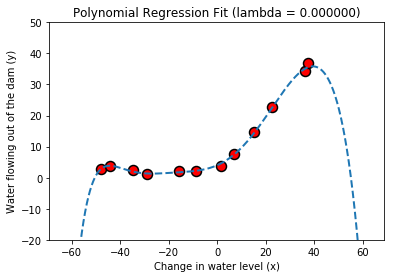

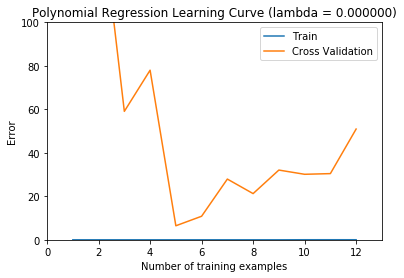

In [11]:
lambda_ = 0
theta = utils.trainLinearReg(linearRegCostFunction, X_poly, y,
                             lambda_=lambda_, maxiter=55)

# Plot training data and fit
pyplot.plot(X, y, 'ro', ms=10, mew=1.5, mec='k')

utils.plotFit(polyFeatures, np.min(X), np.max(X), mu, sigma, theta, p)

pyplot.xlabel('Change in water level (x)')
pyplot.ylabel('Water flowing out of the dam (y)')
pyplot.title('Polynomial Regression Fit (lambda = %f)' % lambda_)
pyplot.ylim([-20, 50])

pyplot.figure()
error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, lambda_)
pyplot.plot(np.arange(1, 1+m), error_train, np.arange(1, 1+m), error_val)

pyplot.title('Polynomial Regression Learning Curve (lambda = %f)' % lambda_)
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
pyplot.axis([0, 13, 0, 100])
pyplot.legend(['Train', 'Cross Validation'])

print('Polynomial Regression (lambda = %f)\n' % lambda_)
print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

You should see that the polynomial fit is able to follow the datapoints very well, thus, obtaining a low training error. The figure on the right shows that the training error essentially stays zero for all numbers of training samples. However, the polynomial fit is very complex and even drops off at the extremes. This is an indicator that the polynomial regression model is overfitting the training data and will not generalize well.

To better understand the problems with the unregularized ($\lambda = 0$) model, you can see that the learning curve shows the same effect where the training error is low, but the cross validation error is high. There is a gap between the training and cross validation errors, indicating a high variance problem.

One way to combat the overfitting (high-variance) problem is to add regularization to the model. In the next section, i will try different $\lambda$ parameters to see how regularization can lead to a better model.

## 3.2 Adjusting the regularization parameter
In this section, i will get to observe how the regularization parameter affects the bias-variance of regularized polynomial regression. First try is $\lambda = 1, then  $\lambda = 100. For each of these values, the script should generate a polynomial fit to the data and also a learning curve.

For $\lambda = 1$, the generated plots should look like the the figure below. You should see a polynomial fit that follows the data trend well (left) and a learning curve (right) showing that both the cross validation and training error converge to a relatively low value. This shows the $\lambda = 1$ regularized polynomial regression model does not have the high-bias or high-variance problems. In effect, it achieves a good trade-off between bias and variance.

![Polynomial Regression, lambda = 1](Figures/polynomial_regression_reg_1.png)
![Polynomial Learning Curve, lambda = 1](Figures/polynomial_learning_curve_reg_1.png)

For $\lambda = 100$, you should see a polynomial fit (figure below) that does not follow the data well. In this case, there is too much regularization and the model is unable to fit the training data.
![Polynomial Regression, lambda = 100](Figures/polynomial_regression_reg_100.png) 

# 3.3 Selecting $\lambda$ using a cross validation set
From the previous parts of the exercise, you observed that the value of $\lambda$ can significantly affect the results of regularized polynomial regression on the training and cross validation set. In particular, a model without regularization ($\lambda = 0$) fits the training set well, but does not generalize. Conversely, a model with too much regularization ($\lambda = 100$) does not fit the training set and testing set well. A good choice of $\lambda$ (e.g., $\lambda = 1$) can provide a good fit to the data.

In this section, you will implement an automated method to select the $\lambda$ parameter. **Concretely**, you will use a cross validation set to evaluate how good each $\lambda$ value is. After selecting the best $\lambda$ value using the cross validation set, we can then evaluate the model on the test set to estimate how well the model will perform on actual unseen data.

Your task is to complete the code in the function validationCurve. Specifically, you should should use the utils.trainLinearReg function to train the model using different values of $\lambda$ and compute the training error and cross validation error. You should try $\lambda$ in the following range: {0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10}.

In [17]:
def validationCurve(X, y, Xval, yval):
    # Selected values of lambda (you should not change this)
    lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

    # You need to return these variables correctly.
    error_train = np.zeros(len(lambda_vec))
    error_val = np.zeros(len(lambda_vec))

    # ============================================================
 
    # ============================================================
    return lambda_vec, error_train, error_val